# Использование LDA в задаче классификации лиц людей

Рассмотрим применение метода LDA для решения задачи классификации лиц людей. [Источник вдохновения](https://iopscience.iop.org/article/10.1088/1742-6596/1028/1/012119/pdf)

## Загрузка данных

In [1]:
!gdown 1A_7QMxQMypTp_ZaioOiBhrglQjPUxyz4
!unzip persons_pics.zip

Downloading...
From: https://drive.google.com/uc?id=1A_7QMxQMypTp_ZaioOiBhrglQjPUxyz4
To: /content/persons_pics.zip
100% 9.64M/9.64M [00:00<00:00, 53.1MB/s]
Archive:  persons_pics.zip
  inflating: persons_pics.csv        
  inflating: __MACOSX/._persons_pics.csv  


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('persons_pics.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.315033,0.333333,0.397386,0.467974,0.402614,0.337255,0.420915,0.495425,0.473203,0.498039,...,0.447059,0.458824,0.432680,0.400000,0.362092,0.373856,0.525490,0.606536,0.465359,Tony Blair
1,0.117647,0.223529,0.317647,0.334641,0.362092,0.386928,0.368627,0.351634,0.354248,0.341176,...,0.230065,0.203922,0.235294,0.283660,0.271895,0.247059,0.303268,0.407843,0.520261,Gerhard Schroeder
2,0.363399,0.253595,0.197386,0.249673,0.258824,0.274510,0.305882,0.311111,0.296732,0.292810,...,0.664052,0.669281,0.687582,0.690196,0.707190,0.732026,0.518954,0.179085,0.312418,Donald Rumsfeld
3,0.551634,0.564706,0.518954,0.401307,0.343791,0.390850,0.379085,0.405229,0.483660,0.475817,...,0.383007,0.396078,0.411765,0.427451,0.449673,0.461438,0.439216,0.416993,0.454902,George W Bush
4,0.354248,0.356863,0.415686,0.322876,0.354248,0.528105,0.618301,0.648366,0.670588,0.700654,...,0.337255,0.366013,0.469281,0.656209,0.810458,0.882353,0.913726,0.939869,0.942484,George W Bush


In [ ]:
df.shape

Имеем $1560$ изображений. Каждое изображение размера $62\times 47$ пикселей.

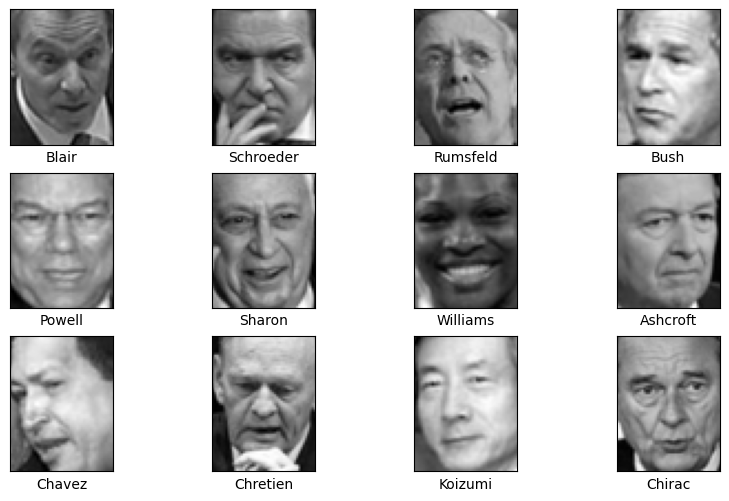

In [3]:
# Список уникальных лиц
labels = df.label.unique()
# Первая встреча каждого лица в датасете
examples = [df[df.label==labels[i]].iloc[0].drop('label') for i in range(len(labels))]

import matplotlib.pyplot as plt

# Отобразить выбранные лица
def get_img_by_row(pic,idx):
  return pic.astype(float).to_numpy().reshape(62,47), labels[idx]
fig, ax = plt.subplots(3, 4, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(examples[i], i)
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])


## Бейзлайн (логрег)

Данные есть, почему бы не попробовать сразу произвести классификацию. Рассмотрим в качестве базового алгоритма логистическую регрессию. Метрика — `f1_score`.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label'],axis=1), df['label'], test_size=0.2, random_state=42, stratify=df['label'])

lr = LogisticRegression(solver='lbfgs', random_state=42).fit(X_train, y_train)
y_pred = lr.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8089062321657329

Ошибка сходимости минимизационной задачи. Сказывается большое число признаков: потенциальная мультиколлинеарность, "плоская" функция потерь и т.п. Увеличим макс число итераций (время сильно подрастет).

In [7]:
lr = LogisticRegression(solver='lbfgs', random_state=42, max_iter=10000).fit(X_train, y_train)
y_pred = lr.predict(X_test)

raw_data = {}
raw_data['Logreg'] = f1_score(y_test, y_pred, average='weighted')
raw_data['Logreg']

0.8023879762469931

In [8]:
lr.coef_.shape

(12, 2914)

In [9]:
lr.classes_

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype=object)

Можно визуализировать веса модели. Угадываются силуэты соответствующих лиц.

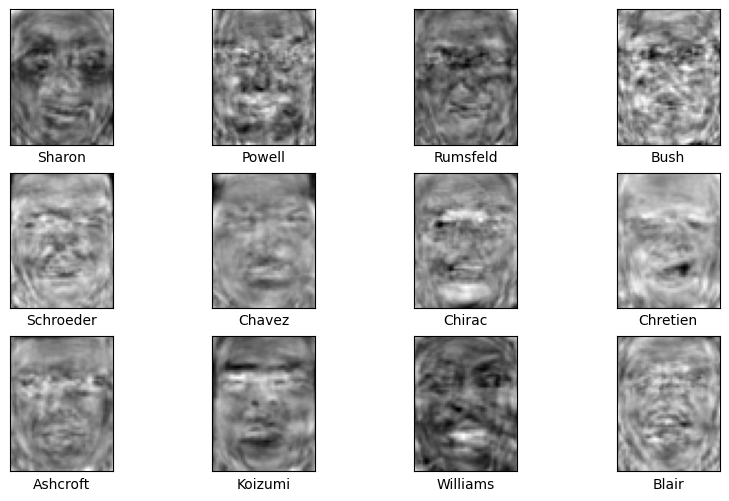

In [10]:
# Отобразить выбранные лица
fig, ax = plt.subplots(3, 4, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    img, lbl = lr.coef_[i].reshape(62,47), lr.classes_[i]
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

## LDA Классификация

Построим "усредненное лицо" каждого класса.

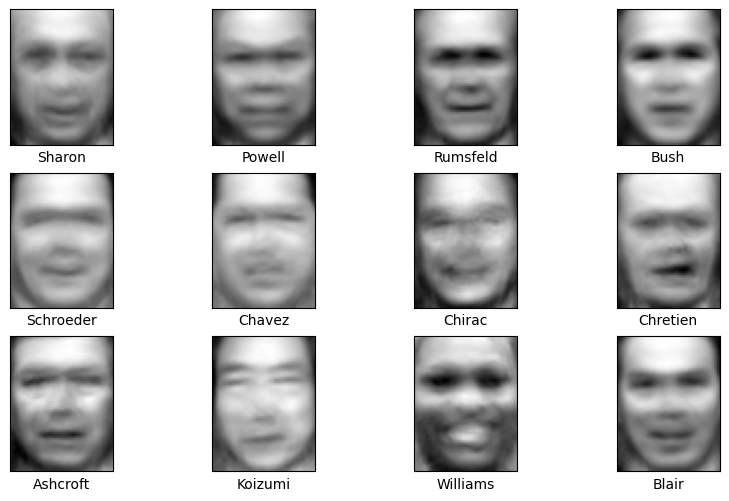

In [11]:
mean_vectors = df.groupby(by='label').mean()

fig, ax = plt.subplots(3, 4, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    img, lbl = mean_vectors.iloc[i].to_numpy().reshape(62,47), mean_vectors.index[i]
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

Задумаемся вот над чем. Каждый класс можно рассматривать в качестве некоторой многомерной случайной величины — человек то один и тот же. Конкретное изображение — реализация этой случайной величины. Если допустить, что фотографии конкретного человека распределены "нормально" относительно его "истинного" (усредненного) изображения (отклонения по гримасе лица, освещению и т.п.), то в таком ключе LDA — как нельзя лучше подходит для задачи классификации.

LDA Классификация на исходных данных

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
y_pred = lda.predict(X_test)
raw_data['LDA'] = f1_score(y_test, y_pred, average='weighted')
raw_data['LDA']

0.6298575228197703

Что-то явно пошло не так. Почему?

Мы столкнулись с проблемой малой выборки. Для LDA необходимо вычислить обратную ковариационную матрицу размером `2914x2914`. Однако количество наших тренировочных изображений намного меньше числа признаков. Это приводит к тому, что ковариационная матрица становится сингулярной (вырожденной), и найти ее обратную матрицу математически невозможно.

`sklearn` обходит эту проблему с помощью специальных вычислительных методов (SVD-разложения), но основная проблема остается: данных слишком мало для такого большого количества признаков, что ведет к сильному переобучению и нестабильной модели.

**Вывод:** напрямую LDA на "сырых" изображениях использовать нельзя.

## Добавляем PCA

Понятно (привет MNIST), что изображения, подобные нашим, содержат большое количество лишней информации. В случае с тем же MNIST использование PCA, позволяет в разы уменьшить размерность признаков практически без потери качества классификации. Почему-бы не попробовать PCA как метод предобработки данных и тут.

In [14]:
from sklearn.decomposition import PCA

# Оставим 90% информации

pca = PCA(n_components=0.9, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca.n_components_

np.int64(94)

Было $2914$ признаков, стало $94$. Комментарии излишни.

### PCA + (логрег)

In [15]:
lr = LogisticRegression(solver='lbfgs', random_state=42).fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)
pca_data = {}
pca_data['Logreg'] = f1_score(y_test, y_pred, average='weighted')
pca_data['Logreg']


0.7619495885078724

In [16]:
lr.coef_.shape

(12, 94)

Попробуем визуализировать коэффициенты логистической регрессии в этом случае.

In [17]:
print('Изначальное соотношение сторон: ', np.round(62/47,2))

Изначальное соотношение сторон:  1.32


In [18]:
# 62*47 = 2914
# 1.32*w*w = 93
w = (94/1.32)**0.5
h = 1.32*w
print('Высота, ширина: ', h,w)

Высота, ширина:  11.139120252515456 8.43872746402686


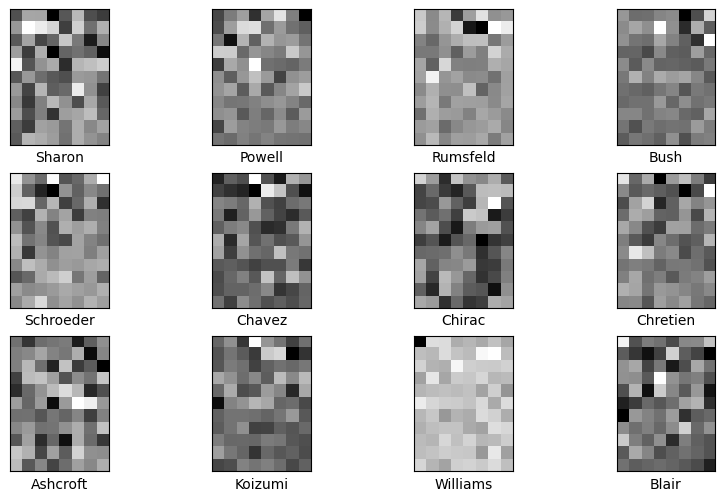

In [19]:
fig, ax = plt.subplots(3, 4, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    img, lbl = lr.coef_[i][:-6].reshape(11, -1), lr.classes_[i]
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

Качество классификации немного "просело", зато модель обучается без проблем и заметно быстрее.

### PCA + LDA классификация (Fisherface)

In [20]:
lda = LinearDiscriminantAnalysis().fit(X_train_pca, y_train)
y_pred = lda.predict(X_test_pca)
pca_data['LDA'] = f1_score(y_test, y_pred, average='weighted')
pca_data['LDA']


0.8165247986232473

In [21]:
lda.coef_.shape

(12, 94)

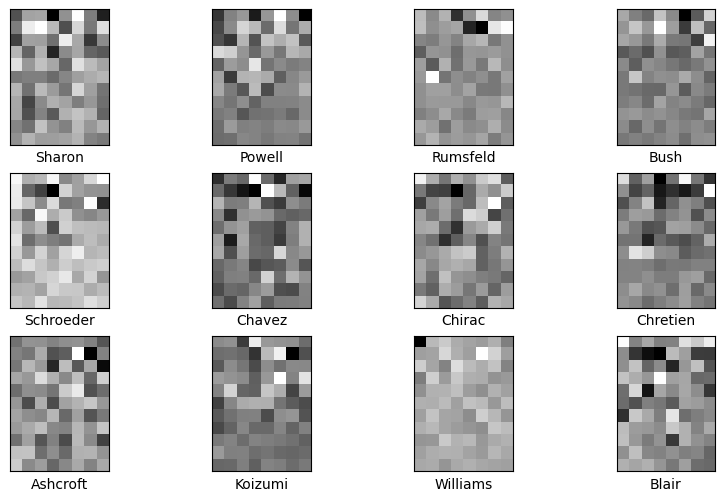

In [22]:
fig, ax = plt.subplots(3, 4, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    img, lbl = lda.coef_[i][:-6].reshape(11, -1), lda.classes_[i]
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

<Axes: >

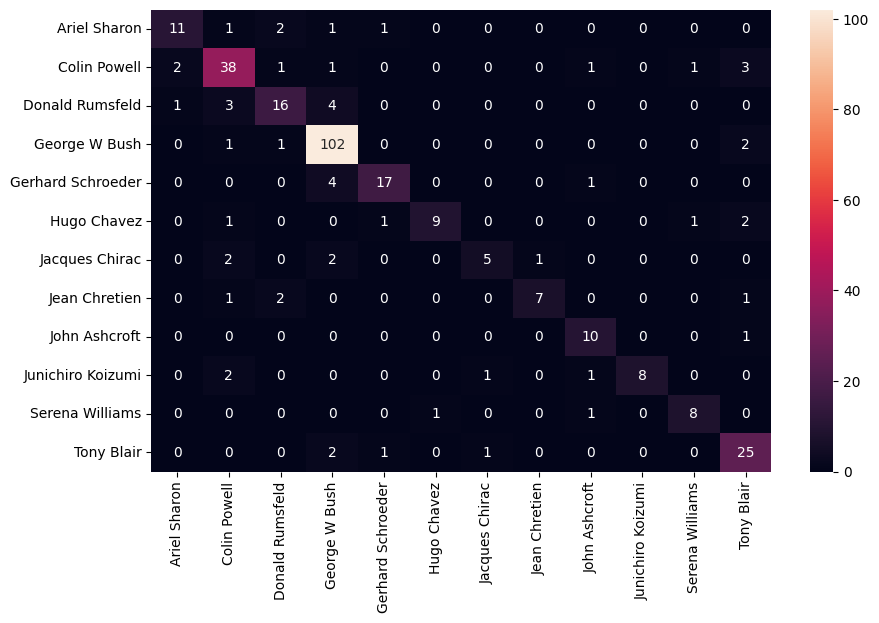

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10, 6))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=lda.classes_, index=lda.classes_)
sns.heatmap(cm, annot=True, fmt='d')

Видно, что после снижения размерности LDA явно хорошо справилась с задачей. По сути PCA убирает лишний "шум" если его так можно назвать, LDA в силу того, что данные по своей природе хорошо укладываются в идею метода (очень похожие объекты в рамках одного класса) хорошо разделяет "дискриминирует" классы.

## PCA + LDA (снижение размерности)

### Логрег

Кроме классификации, LDA можно также использовать и для задачи снижения размерности. При этом, если число классов равно $C$, то можно получить $C-1$ компоненту (новых признаков) в результате применения LDA.

In [24]:
lda = LinearDiscriminantAnalysis(n_components=None)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

# Всего 11 признаков
X_train_lda.shape

(1248, 11)

In [25]:
lr = LogisticRegression(solver='lbfgs', random_state=42).fit(X_train_lda, y_train)
y_pred = lr.predict(X_test_lda)
pca_lda_data = {}
pca_lda_data["Logreg"] = f1_score(y_test, y_pred, average='weighted')
pca_lda_data["Logreg"]

0.8078333462696392

Как результат — снижение размерности в $\frac{2914}{11} \approx 265$ раз и абсолютно сопоставимое качество классификации (в случае логистической регрессии).

### KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Исходные изображения
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
raw_data["KNN"] = f1_score(y_test, y_pred, average='weighted')
raw_data["KNN"]

0.4943645251226596

In [28]:
# PCA
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train_pca, y_train)
y_pred = neigh.predict(X_test_pca)
pca_data["KNN"] = f1_score(y_test, y_pred, average='weighted')
pca_data["KNN"]


0.5814771550488091

In [29]:
# PCA + LDA
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train_lda, y_train)
y_pred = neigh.predict(X_test_lda)
pca_lda_data["KNN"] = f1_score(y_test, y_pred, average='weighted')
pca_lda_data["KNN"]

0.8122722068925423

In [32]:
#соберем все полученные F1-scores в словарь
scores = {
    'Logreg': [raw_data["Logreg"], pca_data["Logreg"], pca_lda_data["Logreg"]],
    'LDA (классификатор)': [raw_data["LDA"], pca_data["LDA"], None], # LDA как классификатор после LDA-преобразования не имеет смысла
    'k-NN (k=15)': [raw_data["KNN"], pca_data["KNN"], pca_lda_data["KNN"]]
}

#pandas DataFrame из словаря
results_df = pd.DataFrame.from_dict(
    scores,
    orient='index',
    columns=['Сырые данные', 'PCA-признаки', 'PCA + LDA признаки']
)

#стилизация: форматирование и выделение максимума
styled_df = results_df.style.format('{:.4f}', na_rep="-").highlight_max(
    axis=0,
    props='font-weight: bold;' # Убрали цвет, оставили только жирность
)

styled_df

,Сырые данные,PCA-признаки,PCA + LDA признаки
Logreg,0.8024,0.7619,0.8078
LDA (классификатор),0.6299,0.8165,-
k-NN (k=15),0.4944,0.5815,0.8123
